In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gdown
import os
import yaml

from core.controllers.quadrotor_diffusion_policy import build_networks_from_config
from core.dataset.quadrotor_dataset import PlanarQuadrotorStateDataset
from core.trainers.quadrotor_diffusion_policy_trainer import PlanarQuadrotorDiffusionPolicyTrainer

/home/yif/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yif/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Load config

In [3]:
with open("config/config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Download dataset

In [4]:
dataset_path = "trn_data.joblib"
if not os.path.isfile(dataset_path):
    gdown.download(id="14safYt34YKn21vL9c_BsRHaG_URPB4Dp", output=dataset_path, quiet=False)

## Load dataset and instantiate the NN

In [29]:
dataset = PlanarQuadrotorStateDataset(dataset_path=dataset_path, config=config)
print("Dataset loaded successfully.")

net = build_networks_from_config(config)
print("Networks initialized successfully.")

desired_state 291
state 291
obs_encode 291
obs_encode (234, 49)
111111action (122743, 6)
222222obs (122743, 6)
333obstacle (122743, 49)
Dataset loaded successfully.
Networks initialized successfully.


In [11]:
s = dataset.__getitem__(0)
print('111111',s["action"].shape) # pred_horizon, action_dim
print('222222',s["obs"].shape) # obs_horizon * obs_dim + 7x7, -
print('333',s["obstacle"].shape) # pred_horizon, 7x7

(96, 6)
(96, 49)
111111 (96, 6)
222222 (61,)
333 (96, 49)


In [14]:
dataset.__len__()

98008

## Instantiate the trainer

In [30]:
trainer = PlanarQuadrotorDiffusionPolicyTrainer(
    net=net,
    dataset=dataset,
    config=config,
)

## Start training

In [33]:
trainer.train(num_epochs=100, save_ckpt_epoch=50)
trainer.save_checkpoint("ckpt_final.ckpt")

!!!!!! len(self.indices) 98008


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

!!!!!! len(self.indices) 98008


!!!!!! len(self.indices) 98008
!!!!!! len(self.indices) 98008


Epoch:   0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Trainnig data visualization
The training data was generated using a MPPI-CBF controller from [shaoanlu/mppi_cbf](https://github.com/shaoanlu/mppi_cbf) repository. 

In [15]:
import joblib
import numpy as np
from matplotlib import pyplot as plt

In [16]:
def visualize_dataset(data):
    """
    Shows 20 samples in the dataset.
    Each subplot illustrates a training trajectory consisting of:
    - The starting position as a green dot;
    - The goal position as a red dot;
    - The positon of the quadrotor is the blue line; and
    - The obstacles are presented as grey circles.
    """
    plt.figure(figsize=(10, 8))
    for i in range(20):
        rand_idx = np.random.randint(len(data["state"]))
        s = data["state"][rand_idx]
        # des_s = data["desired_state"][rand_idx]
        info = data["info"][rand_idx]
        x, y = s[:, 0], s[:, 2]
        # des_x, des_y = des_s[:, 0], des_s[:, 2]
    
        plt.subplot(4, 5, i+1)
        for obs_idx in range(len(info["obs_center"])):
            circle = plt.Circle((info["obs_center"][obs_idx, 0], info["obs_center"][obs_idx, 1]), info["obs_radius"][obs_idx], color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
            plt.gca().add_artist(circle)
        plt.scatter(data["state"][rand_idx][0, 0], data["state"][rand_idx][0, 2], color="green")
        plt.scatter(5, 5, color="red")
        plt.plot(x, y)
        # plt.plot(des_x, des_y, ":")
        plt.grid()
        plt.xlim(-1, 7)
        plt.ylim(-1, 7)
    plt.tight_layout()
    plt.show()

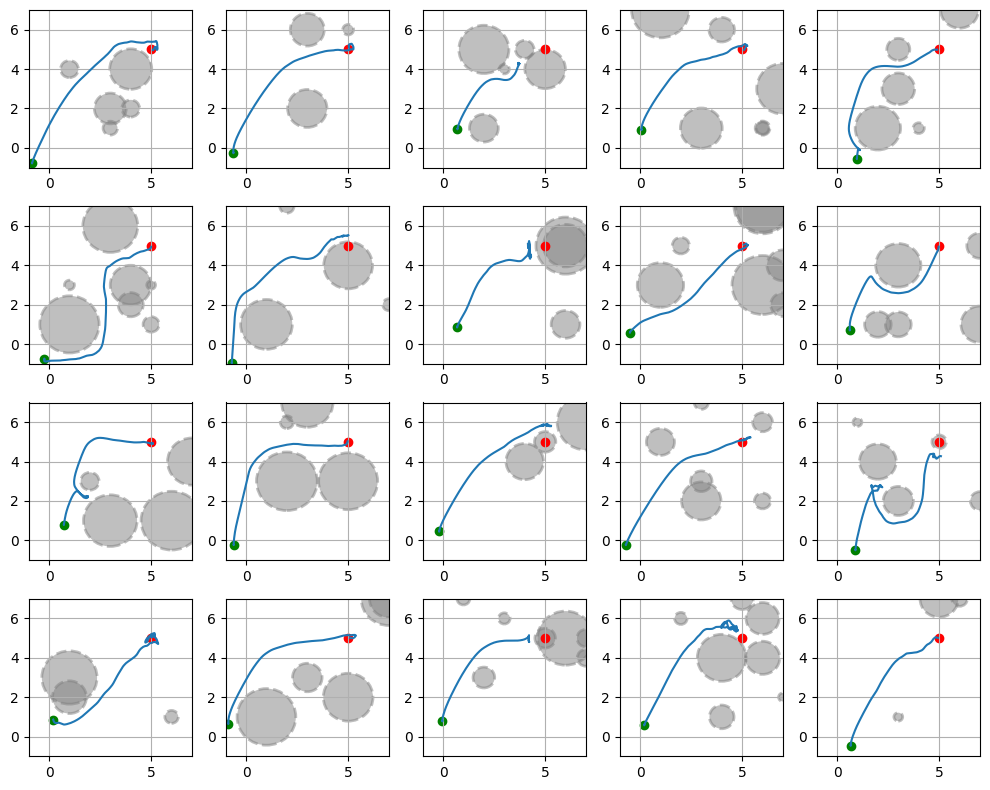

In [17]:
trn_data = joblib.load("trn_data.joblib")
visualize_dataset(trn_data)

In [24]:
for key, value in trn_data.items():
    print(f"{key}: {len(value)}")
print('------------------')
print('state',len(trn_data["state"]))
print('desired_state',len(trn_data["desired_state"]))
print('control',len(trn_data["control"]))
print('info',len(trn_data["info"]))
print('------------------')

print('state',trn_data["state"][0].shape)
print('desired_state',trn_data["desired_state"][0].shape)
print('control',trn_data["control"][0].shape)


state: 291
desired_state: 291
control: 291
info: 291
------------------
state 291
desired_state 291
control 291
info 291
------------------


AttributeError: 'list' object has no attribute 'shape'